In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input, optimizers, Model
from tensorflow.keras.layers import Layer, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from scipy import spatial

In [2]:
triplets = np.load('triplets_array.npy')

triplets = triplets/255 #normalize by 255
labels = np.ones(len(triplets)) #create a fixed label

assert triplets.shape == (30000,3,32,32,3)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    triplets,
    labels,
    test_size=0.05,
    random_state=42
)

In [4]:
pretrained_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(32,32,3)
)

for layer in pretrained_model.layers:
    layer.trainable = True

In [5]:
def cosine_distance(x,y):
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    distance = 1 - K.batch_dot(x, y, axes=-1)
    return distance

def triplet_loss(templates, margin=0.4):
    
    anchor,positive,negative = templates
    
    positive_distance = cosine_distance(anchor,positive)
    negative_distance = cosine_distance(anchor,negative)
    
    basic_loss = positive_distance-negative_distance+margin
    loss = K.maximum(basic_loss,0.0)
    
    return loss

In [6]:
anchor = Input(shape=(32, 32,3), name='anchor_input')
A = pretrained_model(anchor)

positive = Input(shape=(32, 32,3), name='positive_input')
P = pretrained_model(positive)

negative = Input(shape=(32, 32,3), name='negative_input')
N = pretrained_model(negative)

loss = Lambda(triplet_loss)([A, P, N])

model = Model(inputs=[anchor,positive,negative],outputs=loss)


In [7]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

model.compile(loss=identity_loss, optimizer=Adam(learning_rate=1e-4))

callbacks=[EarlyStopping(
    patience=2, 
    verbose=1, 
    restore_best_weights=True,
    monitor='val_loss'
    )]

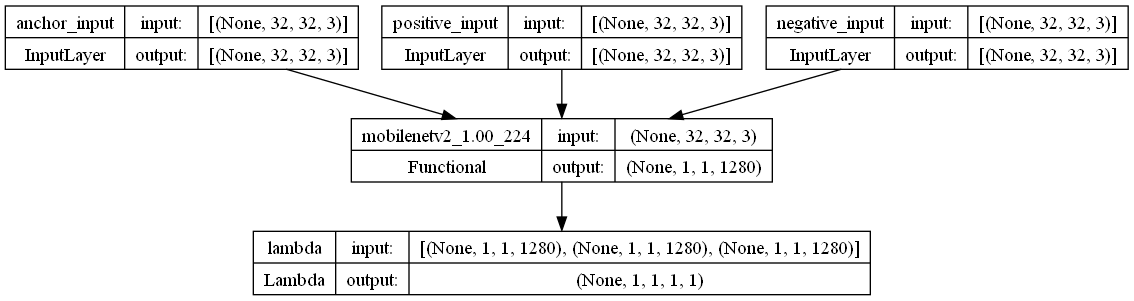

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='siamese_triplet_loss_model.png')

In [9]:
model.fit(
    [X_train[:,0],X_train[:,1],X_train[:,2]],
    y_train,
    epochs=50, 
    batch_size=64,
    validation_data=([X_test[:,0],X_test[:,1],X_test[:,2]],y_test),
    callbacks=callbacks
)

Epoch 1/50
446/446 [==============================] - 33s 39ms/step - loss: 0.3408 - val_loss: 0.3619
Epoch 2/50
446/446 [==============================] - 16s 36ms/step - loss: 0.2290 - val_loss: 0.2659
Epoch 3/50
446/446 [==============================] - 16s 35ms/step - loss: 0.1866 - val_loss: 0.2017
Epoch 4/50
446/446 [==============================] - 16s 36ms/step - loss: 0.1599 - val_loss: 0.1803
Epoch 5/50
446/446 [==============================] - 16s 36ms/step - loss: 0.1398 - val_loss: 0.1644
Epoch 6/50
446/446 [==============================] - 16s 36ms/step - loss: 0.1343 - val_loss: 0.1659
Epoch 7/50
446/446 [==============================] - 16s 36ms/step - loss: 0.1174 - val_loss: 0.1485
Epoch 8/50
446/446 [==============================] - 19s 42ms/step - loss: 0.1033 - val_loss: 0.1399
Epoch 9/50
446/446 [==============================] - 18s 40ms/step - loss: 0.0940 - val_loss: 0.1362
Epoch 10/50
446/446 [==============================] - 18s 40ms/step - loss: 0.084

In [10]:
X_test_anchor = X_test[:,0]
X_test_positive = X_test[:,1]
X_test_negative = X_test[:,2]

siamese_model = model.layers[3]

X_test_anchor_template = np.squeeze(siamese_model.predict(X_test_anchor))
X_test_positive_template = np.squeeze(siamese_model.predict(X_test_positive))
X_test_negative_template = np.squeeze(siamese_model.predict(X_test_negative))

y_test_targets = np.concatenate([np.ones((len(X_test),)),np.zeros((len(X_test),))])

47/47 [==============================] - 0s 5ms/step


In [11]:
def angular_similarity(template1,template2):
    
    score = np.float32(1-np.arccos(1-spatial.distance.cosine(template1,template2))/np.pi)
    
    return score

y_predict_targets = []

for index in range(len(X_test)):
    similarity = angular_similarity(X_test_anchor_template[index],X_test_positive_template[index])
    y_predict_targets.append(similarity)
    
for index in range(len(X_test)):
    similarity = angular_similarity(X_test_anchor_template[index],X_test_negative_template[index])
    y_predict_targets.append(similarity)

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

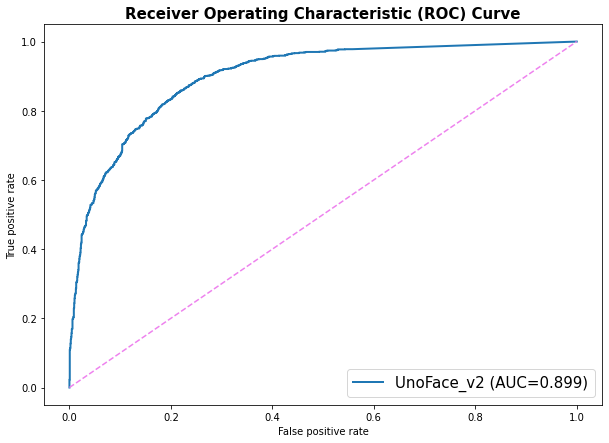

In [12]:
fpr, tpr, thresholds = roc_curve(y_test_targets, y_predict_targets)

fig = plt.figure(figsize=[10,7])
plt.plot(fpr, tpr,lw=2,label='UnoFace_v2 (AUC={:.3f})'.format(roc_auc_score(y_test_targets, y_predict_targets)))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right",fontsize=15)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15)

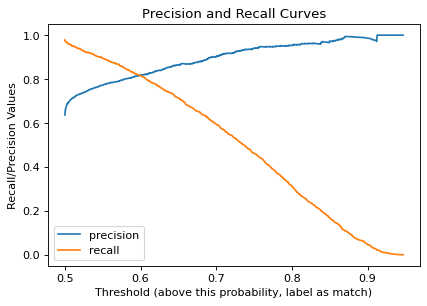

In [13]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_targets, y_predict_targets)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as match)');
plt.ylabel('Recall/Precision Values');
plt.title('Precision and Recall Curves');

In [14]:
positive_comparisons = X_test[:,[0,1]]
negative_comparisons = X_test[:,[0,2]]

positive_predict_targets = np.array(y_predict_targets)[:1500]
negative_predict_targets = np.array(y_predict_targets)[1500:]

assert positive_comparisons.shape == (1500,2,32,32,3)
assert negative_comparisons.shape == (1500,2,32,32,3)

assert positive_predict_targets.shape == (1500,)
assert negative_predict_targets.shape == (1500,)

np.random.seed(21)
NUM_EXAMPLES = 5
random_index = np.random.choice(range(len(positive_comparisons)),NUM_EXAMPLES)

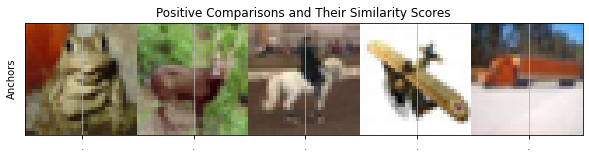

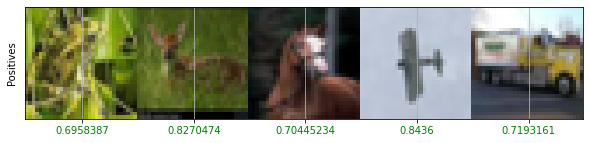

In [17]:
plt.figure(figsize=(10,4))
plt.title('Positive Comparisons and Their Similarity Scores')
plt.ylabel('Anchors')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], ['.' for x in range(NUM_EXAMPLES)])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('green') 
plt.grid(None)
anchor = np.swapaxes(positive_comparisons[:,0][random_index],0,1)
anchor = np.reshape(anchor,[32,NUM_EXAMPLES*32,3])
plt.imshow(anchor)

plt.figure(figsize=(10,4))
plt.ylabel('Positives')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], positive_predict_targets[random_index])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('green') 
plt.grid(None)
positive = np.swapaxes(positive_comparisons[:,1][random_index],0,1)
positive = np.reshape(positive,[32,NUM_EXAMPLES*32,3])
plt.imshow(positive)


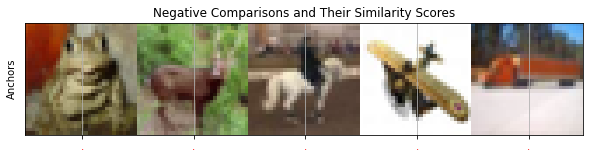

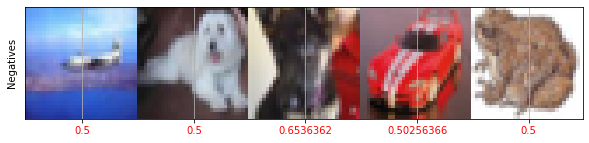

In [18]:
plt.figure(figsize=(10,4))
plt.title('Negative Comparisons and Their Similarity Scores')
plt.ylabel('Anchors')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], ['.' for x in range(NUM_EXAMPLES)])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('red') 
plt.grid(None)
anchor = np.swapaxes(positive_comparisons[:,0][random_index],0,1)
anchor = np.reshape(anchor,[32,NUM_EXAMPLES*32,3])
plt.imshow(anchor)

plt.figure(figsize=(10,4))
plt.ylabel('Negatives')
plt.yticks([])
plt.xticks([32*x+16 for x in range(NUM_EXAMPLES)], negative_predict_targets[random_index])
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    t.set_color('red') 
plt.grid(None)
negative = np.swapaxes(negative_comparisons[:,1][random_index],0,1)
negative = np.reshape(negative,[32,NUM_EXAMPLES*32,3])
plt.imshow(negative)